In [1]:
path='G:/Shared drives/BeStarsMiMeS/UpdatedFiles/' #Patrick's google file stream path

import LSDpy.lsdpy
import specpolFlow as pol


import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import itertools

import pyRaven as rav

In [2]:
#Accessing the google sheets

sheet_id = '1M6y1Wnsrc-w5FjUMfKaSFa_-foIDAaMe8W4lYNWnWyk'
sheet_name = 'Stars'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
StarData=pd.read_csv(url)

sheet_name = 'Observations'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Observations=pd.read_csv(url)

In [3]:
def read_disk(file):
  '''
  Read a synthetic spectrum from a s3div output

  :param file: The filename
  :rtype: wave, flux -- the wavelength in nm, and the normalized flux. 
  '''
  with open(file) as f:
    lines = f.readlines()
  # number of atomic lines in the header of the file
  natomic = int(lines[0].split(sep='-')[0])
  nwave=int(lines[natomic+1].split()[0])
  data = np.genfromtxt(lines[natomic+2:natomic+1+nwave])
  return(data[:,0]/10.0, data[:,1])

def split_order(data):
  '''
  Split an observation object into a list of observation objects with one order per item
  '''
  # one order is where the wavelength backtracks. 
  ind = np.where((data.wl[1:]-data.wl[0:-1]) < 0)[0]
  norder = ind.size+1
  ind = np.append(-1,ind)
  ind = np.append(ind,data.wl.size)
  print('{} orders'.format(norder))

  list_order=[]
  for i in range(0,norder):
    list_order.append(data[ind[i]+1:ind[i+1]])
 
  return(list_order)
  
def splice_order(list_order):
  '''
  Concatenate a list of observation objects (usually split into a list of orders by split_order function). Note: it does not merge the orders overlaps.
  '''
  wl = np.array([])
  specI = np.array([])
  specV = np.array([])
  specN1 = np.array([])
  specN2 = np.array([])
  specSig = np.array([])
  for item in list_order:
    wl=np.append(wl,item.wl)
    specI=np.append(specI,item.specI)
    specV=np.append(specV,item.specV)
    specN1=np.append(specN1,item.specN1)
    specN2=np.append(specN2,item.specN2)
    specSig=np.append(specSig, item.specSig)
  return(pol.Spectrum(wl, specI, specV, specN1, specN2, specSig, header=list_order[0].header))

def rshift(wave, radvel):
  '''
  Shift a spectrum in terms of radial velocity. The wavelength array and the velocity arrays must be defied as astropy units quantities.
  The new wavelength array is returned in the same units as the initial wavelength array. 
  '''
  return( (wave + wave*radvel/const.c).to(wave.unit).value )


In [17]:
star = 'hd58343'
vsini = 60
vradCorrected = -10.0 *u.km/u.s

#star = 'hd7636'
#vsini = 230.0
#vradCorrected = 0 * u.km/u.s

file = '{}00-InputMaterial/NormalizedSpectra/{}_2.s'.format(path,star)
data = pol.read_spectrum(file)

#file = 'RanNoise/{}_1_ran_noise'.format(star)
#model = pol.iolsd.read_spectrum(file)

file = '{}01-Synth-calculations/Synth-hybrid-spectra/{}_2_noise.s'.format(path,star)
synth = pol.read_spectrum(file)

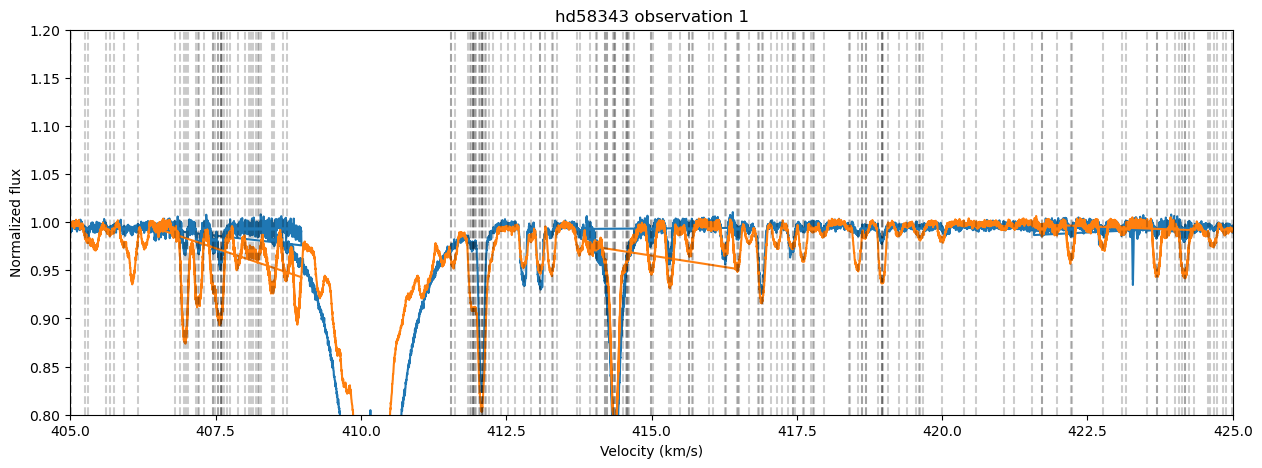

Average observed spec velocity spacing: 1.803704 km/s
using a 121 point profile with 3.000000 km/s pixels
mean mask depth 0.102317 wl 503.183 Lande 1.190717 (from 1115 lines)
mean mask norm weightI 0.511587 weightV 0.498115
I reduced chi2 86.4069 (chi2 8674558.63 constraints 100513 dof 121)
 Rescaling error bars by: 9.295530
V reduced chi2 1.0184 (chi2 102239.80 constraints 100513 dof 121)
 Rescaling error bars by: 1.009161
 removing profile continuum pol: -1.3405e-06 +/- 2.0774e-09 (avg err 4.5502e-05)
N1 reduced chi2 1.0237 (chi2 102768.42 constraints 100513 dof 121)
 Rescaling error bars by: 1.011766
 removing profile continuum pol: -2.0507e-06 +/- 2.0881e-09 (avg err 4.5619e-05)
line range estimate -78.0 66.0 km/s
V in line reduced chi^2 1.010681 (chi2  48.512710) 
 detect prob 0.547834 (fap 4.521658e-01)
 Non-detection V (fap 4.521658e-01)
 V outside line reduced chi^2 0.909096 (chi2  60.909457) 
 detect prob 0.313871 (fap 6.861295e-01)
N1 in line reduced chi^2 0.772132 (chi2  37.

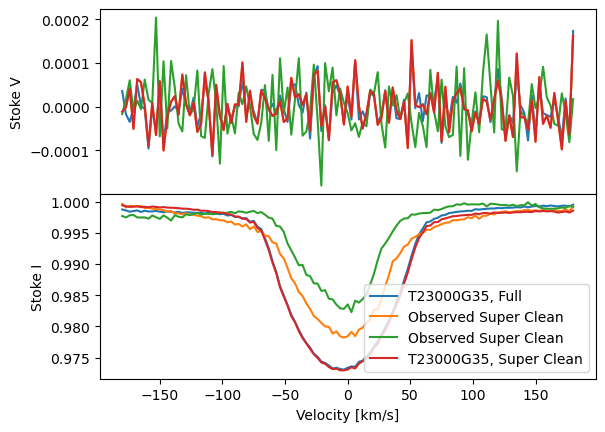

In [20]:
CII = 426.726 *u.nm
HeI =  402.6199 *u.nm
lb=405
ub=425

fig, ax = plt.subplots(1,1, figsize=(15,5))

ax.plot(data.wl, data.specI)
ax.plot(synth.wl, synth.specI)
ax.set_xlim(lb,ub)
ax.set_ylim(0.8, 1.2)
ax.axvline(x=CII.value, c='k', ls='--')
#ax.text(427, 1.05, 'CII 4267')
ax.axvline(x=HeI.value, c='k', ls='--')
#ax.text(403, 1.05, 'HeI 4026')
ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Normalized flux')
ax.set_title('{} observation 1'.format(star))

model='T23000g35'
file_mask='{}02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(path,model.upper())
mask = pol.read_mask(fname=file_mask)

mask_used = mask.wl[mask.iuse==1]
mask_not_used = mask.wl[mask.iuse==0]
element_used=mask.element[mask.iuse==1]
element_not_used=mask.element[mask.iuse==0]

lower=mask_used[mask_used>=lb]
upper=mask_used[mask_used<=ub]
lines=np.intersect1d(lower,upper)
lower_e=element_used[mask_used>=lb]
upper_e=element_used[mask_used<=ub]
elements=np.intersect1d(lower_e,upper_e)

for i in range(lines.size):
    ax.axvline(x=lines[i], c='k', ls='--',alpha=0.2)
    #ax.text(lines[i]-1, 1.05, '{}'.format(elements[i]))
plt.show()

from LSDpy import lsdpy
velS=-180.0
velE=180.0
velP=3.0
outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.lsd'.format(path,model)
toto = lsdpy.main(observation=file, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
lsd = pol.read_lsd(outfile)

UO=pol.read_lsd('{}03-LSD-calculations/LSD/normalized_SuperCleanAsif+tellClean/{}_2.lsd'.format(path,star))

UO2=pol.read_lsd('{}03-LSD-calculations/LSD/normalized_SuperCleanAsif+tellClean/{}_1.lsd'.format(path,star))

UH=pol.read_lsd('{}03-LSD-calculations/LSD/hybrid_SuperCleanAsif+tellClean/{}_2.lsd'.format(path,star))

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(lsd.vel,lsd.specV)
ax[0].plot(UO.vel,UO.specV)
ax[0].plot(UO2.vel,UO2.specV)
ax[0].plot(UH.vel,UH.specV)
ax[1].plot(lsd.vel,lsd.specI,label='{}, Full'.format(model.upper()))
ax[1].plot(UO.vel,UO.specI,label='Observed Super Clean'.format(model.upper()))
ax[1].plot(UO2.vel,UO2.specI,label='Observed Super Clean'.format(model.upper()))
ax[1].plot(UH.vel,UH.specI,label='{}, Super Clean'.format(model.upper()))
ax[0].set_ylabel('Stoke V')
ax[1].set_ylabel('Stoke I')
ax[1].set_xlabel('Velocity [km/s]')
ax[1].legend()
#ax.set_title('Original')

plt.subplots_adjust(wspace=0, hspace=0)

In [541]:
import copy
# reading the observed spectrum
file_obs = '{}00-InputMaterial/NormalizedSpectra/{}_{}.s'.format(path,star, 1)
data_obs = pol.read_spectrum(file_obs)
# splitting the observed spectrum by order
list_order = split_order(data_obs)

vsini=45
ModelCode='T23000G35_45'
file_mod = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.dsk'.format(path,ModelCode)
mod_wave, mod_flux = read_disk(file_mod)
# shifting the model spectrum for its radial velocity
# (note the rshift function asks for numpy unit quantities)

mod_wave_shift = rshift(mod_wave*u.nm, vradCorrected)

for order in list_order:

  # interpolate the shifted model onto the order grid
  mod_flux_interp = np.interp(order.wl, mod_wave_shift, mod_flux)

  # drawing n random elements with a mean of zero and a stdev of 1.0
  # scaling to a sigma corresponding to the error bar
  noise = np.random.standard_normal(order.wl.size)*order.specSig
  mod_flux_interp = mod_flux_interp + noise
  # replacing the flux array in the order
  order.specI = copy.deepcopy(mod_flux_interp)

# putting the orders back together
new = splice_order(list_order)

### writting back the file in the proper folder. 
## need to look for a write function for .s, maybe in Colin's 
## normalization code?

new.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode))

37 orders


In [29]:
import copy
# reading the observed spectrum
file_obs = '{}00-InputMaterial/NormalizedSpectra/{}_{}.s'.format(path,star, 1)
data_obs = pol.read_spectrum(file_obs)
# splitting the observed spectrum by order
list_order = split_order(data_obs)


ModelCode2='T23000G35'
file_mod = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.dsk'.format(path,ModelCode2)
mod_wave, mod_flux = read_disk(file_mod)
# shifting the model spectrum for its radial velocity
# (note the rshift function asks for numpy unit quantities)

mod_wave_shift = rshift(mod_wave*u.nm, vradCorrected)

for order in list_order:

  # interpolate the shifted model onto the order grid
  mod_flux_interp = np.interp(order.wl, mod_wave_shift, mod_flux)

  # drawing n random elements with a mean of zero and a stdev of 1.0
  # scaling to a sigma corresponding to the error bar
  noise = np.random.standard_normal(order.wl.size)*order.specSig
  mod_flux_interp = mod_flux_interp + noise
  # replacing the flux array in the order
  order.specI = copy.deepcopy(mod_flux_interp)

# putting the orders back together
new = splice_order(list_order)

### writting back the file in the proper folder. 
## need to look for a write function for .s, maybe in Colin's 
## normalization code?

new.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode2))

37 orders


In [30]:
import copy
# reading the observed spectrum
file_obs = '{}00-InputMaterial/NormalizedSpectra/{}_{}.s'.format(path,star, 1)
data_obs = pol.read_spectrum(file_obs)
# splitting the observed spectrum by order
list_order = split_order(data_obs)


ModelCode3='T17000G35'
file_mod = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.dsk'.format(path,ModelCode3)
mod_wave, mod_flux = read_disk(file_mod)
# shifting the model spectrum for its radial velocity
# (note the rshift function asks for numpy unit quantities)

mod_wave_shift = rshift(mod_wave*u.nm, vradCorrected)

for order in list_order:

  # interpolate the shifted model onto the order grid
  mod_flux_interp = np.interp(order.wl, mod_wave_shift, mod_flux)

  # drawing n random elements with a mean of zero and a stdev of 1.0
  # scaling to a sigma corresponding to the error bar
  noise = np.random.standard_normal(order.wl.size)*order.specSig
  mod_flux_interp = mod_flux_interp + noise
  # replacing the flux array in the order
  order.specI = copy.deepcopy(mod_flux_interp)

# putting the orders back together
new = splice_order(list_order)

### writting back the file in the proper folder. 
## need to look for a write function for .s, maybe in Colin's 
## normalization code?

new.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode3))

37 orders


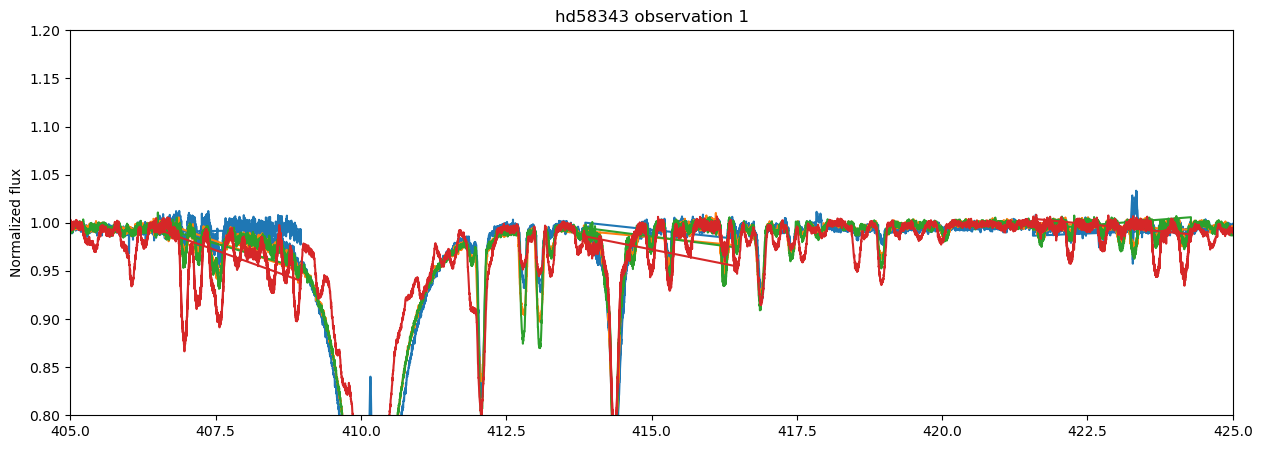

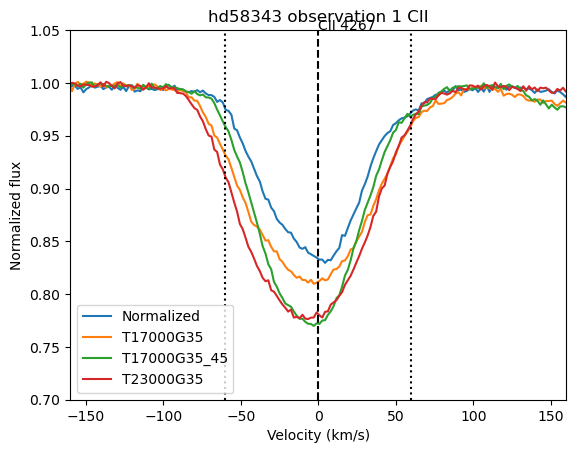

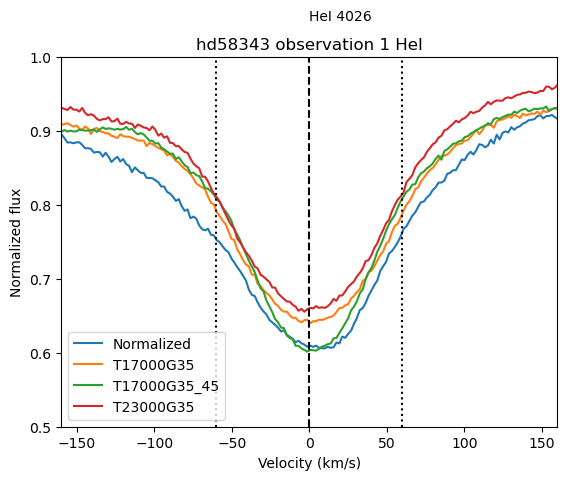

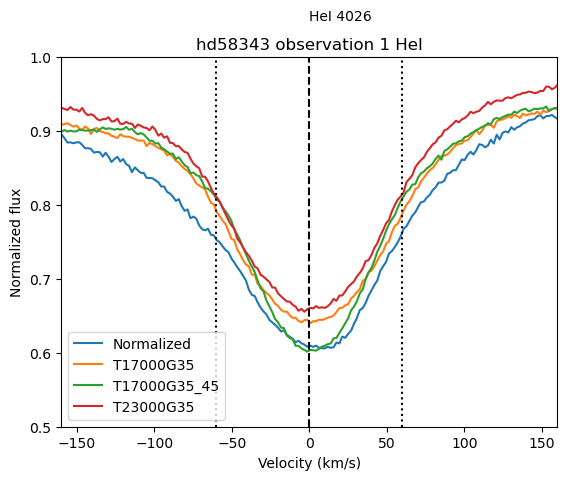

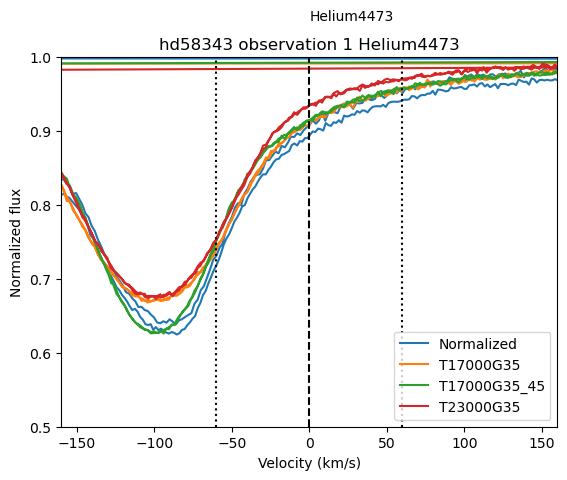

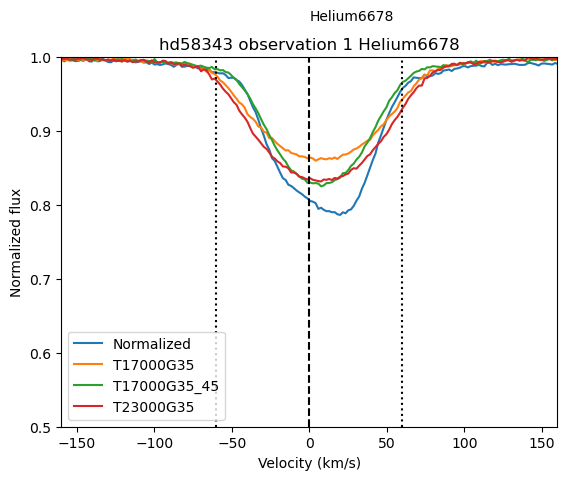

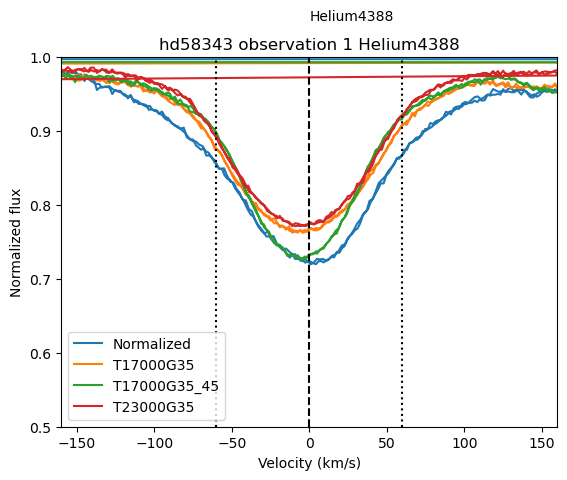

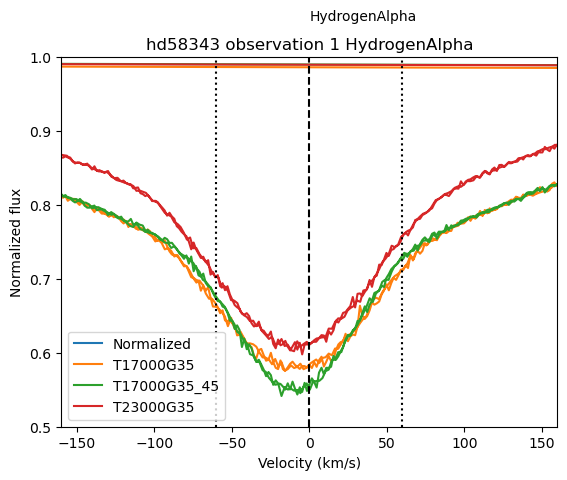

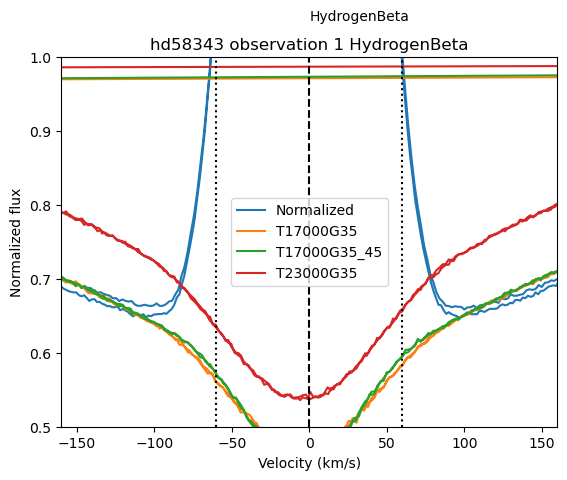

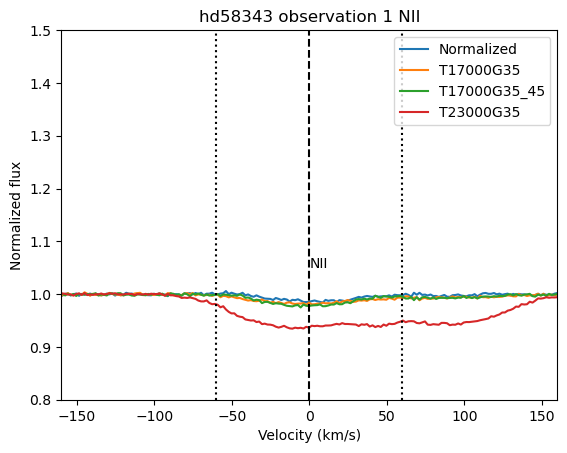

FileNotFoundError: G:/Shared drives/BeStarsMiMeS/UpdatedFiles/02-Mask-calculations/MaskCleaning/depth0.02_tellClean/T17000G35_45_depth0.02.mask not found.

In [492]:
star = 'hd58343'
vsini = 60
vradCorrected = -10.0 *u.km/u.s

file = '{}00-InputMaterial/NormalizedSpectra/{}_1.s'.format(path,star)
data = pol.read_spectrum(file)

file1 = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode3)
synth0 = pol.read_spectrum(file1)

file2 = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode)
synth = pol.read_spectrum(file2)

file3='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/hd58343.s'.format(path)
oldsynth=pol.read_spectrum(file3)

CII = 426.726 *u.nm
HeI =  402.6199 *u.nm
Helium4473 = 447.3 * u.nm
Helium6678 = 667.8 * u.nm
Helium4388= 438.8 * u.nm
HydrogenAlpha = 656.3 * u.nm
HydrogenBeta = 486.14 * u.nm
NII=444.703 *u.nm

lb=405
ub=425

fig, ax = plt.subplots(1,1, figsize=(15,5))

ax.plot(data.wl, data.specI)
ax.plot(synth0.wl, synth0.specI)
ax.plot(synth.wl, synth.specI)
ax.plot(oldsynth.wl, oldsynth.specI)
ax.set_xlim(lb,ub)
ax.set_ylim(0.8, 1.2)
ax.axvline(x=CII.value, c='k', ls='--')
#ax.text(427, 1.05, 'CII 4267')
ax.axvline(x=HeI.value, c='k', ls='--')
#ax.text(403, 1.05, 'HeI 4026')
#ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Normalized flux')
ax.set_title('{} observation 1'.format(star))
plt.show()

vel = ((data.wl*u.nm - CII)/CII * const.c).to(u.km/u.s)
vel0 = ((synth0.wl*u.nm - CII)/CII * const.c).to(u.km/u.s)
vel2 = ((synth.wl*u.nm - CII)/CII * const.c).to(u.km/u.s)
vel3 = ((oldsynth.wl*u.nm - CII)/CII * const.c).to(u.km/u.s)
plt.plot(vel-vradCorrected, data.specI,label='Normalized')
plt.plot(vel0-vradCorrected, synth0.specI,label=ModelCode3)
plt.plot(vel2-vradCorrected, synth.specI,label=ModelCode)
plt.plot(vel3-vradCorrected, oldsynth.specI,label='T23000G35')
plt.xlim(-vsini-100,vsini+100)
plt.ylim(0.7, 1.05)
plt.axvline(x=0, c='k', ls='--')
plt.axvline(x=vsini, c='k', ls='dotted')
plt.axvline(x=-1*vsini, c='k', ls='dotted')
plt.text(0, 1.05, 'CII 4267')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized flux')
plt.title('{} observation 1 CII'.format(star))
plt.legend()
plt.show()

vel = ((data.wl*u.nm - HeI)/HeI * const.c).to(u.km/u.s)
vel0 = ((synth0.wl*u.nm - HeI)/HeI * const.c).to(u.km/u.s)
vel2 = ((synth.wl*u.nm - HeI)/HeI * const.c).to(u.km/u.s)
vel3 = ((oldsynth.wl*u.nm - HeI)/HeI * const.c).to(u.km/u.s)
plt.plot(vel-vradCorrected, data.specI,label='Normalized')
plt.plot(vel0-vradCorrected, synth0.specI,label=ModelCode3)
plt.plot(vel2-vradCorrected, synth.specI,label=ModelCode)
plt.plot(vel3-vradCorrected, oldsynth.specI,label='T23000G35')
plt.xlim(-vsini-100,vsini+100)
plt.ylim(0.5, 1.0)
plt.axvline(x=0, c='k', ls='--')
plt.axvline(x=vsini, c='k', ls='dotted')
plt.axvline(x=-1*vsini, c='k', ls='dotted')
plt.text(0, 1.05, 'HeI 4026')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized flux')
plt.title('{} observation 1 HeI'.format(star))
plt.legend()
plt.show()

vel = ((data.wl*u.nm - HeI)/HeI * const.c).to(u.km/u.s)
vel0 = ((synth0.wl*u.nm - HeI)/HeI * const.c).to(u.km/u.s)
vel2 = ((synth.wl*u.nm - HeI)/HeI * const.c).to(u.km/u.s)
vel3 = ((oldsynth.wl*u.nm - HeI)/HeI * const.c).to(u.km/u.s)
plt.plot(vel-vradCorrected, data.specI,label='Normalized')
plt.plot(vel0-vradCorrected, synth0.specI,label=ModelCode3)
plt.plot(vel2-vradCorrected, synth.specI,label=ModelCode)
plt.plot(vel3-vradCorrected, oldsynth.specI,label='T23000G35')
plt.xlim(-vsini-100,vsini+100)
plt.ylim(0.5, 1.0)
plt.axvline(x=0, c='k', ls='--')
plt.axvline(x=vsini, c='k', ls='dotted')
plt.axvline(x=-1*vsini, c='k', ls='dotted')
plt.text(0, 1.05, 'HeI 4026')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized flux')
plt.title('{} observation 1 HeI'.format(star))
plt.legend()
plt.show()


vel = ((data.wl*u.nm - Helium4473)/Helium4473 * const.c).to(u.km/u.s)
vel0 = ((synth0.wl*u.nm - Helium4473)/Helium4473 * const.c).to(u.km/u.s)
vel2 = ((synth.wl*u.nm - Helium4473)/Helium4473 * const.c).to(u.km/u.s)
vel3 = ((oldsynth.wl*u.nm - Helium4473)/Helium4473 * const.c).to(u.km/u.s)
plt.plot(vel-vradCorrected, data.specI,label='Normalized')
plt.plot(vel0-vradCorrected, synth0.specI,label=ModelCode3)
plt.plot(vel2-vradCorrected, synth.specI,label=ModelCode)
plt.plot(vel3-vradCorrected, oldsynth.specI,label='T23000G35')
plt.xlim(-vsini-100,vsini+100)
plt.ylim(0.5, 1.0)
plt.axvline(x=0, c='k', ls='--')
plt.axvline(x=vsini, c='k', ls='dotted')
plt.axvline(x=-1*vsini, c='k', ls='dotted')
plt.text(0, 1.05, 'Helium4473')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized flux')
plt.title('{} observation 1 Helium4473'.format(star))
plt.legend()
plt.show()

vel = ((data.wl*u.nm - Helium6678)/Helium6678 * const.c).to(u.km/u.s)
vel0 = ((synth0.wl*u.nm - Helium6678)/Helium6678 * const.c).to(u.km/u.s)
vel2 = ((synth.wl*u.nm - Helium6678)/Helium6678 * const.c).to(u.km/u.s)
vel3 = ((oldsynth.wl*u.nm - Helium6678)/Helium6678 * const.c).to(u.km/u.s)
plt.plot(vel-vradCorrected, data.specI,label='Normalized')
plt.plot(vel0-vradCorrected, synth0.specI,label=ModelCode3)
plt.plot(vel2-vradCorrected, synth.specI,label=ModelCode)
plt.plot(vel3-vradCorrected, oldsynth.specI,label='T23000G35')
plt.xlim(-vsini-100,vsini+100)
plt.ylim(0.5, 1.0)
plt.axvline(x=0, c='k', ls='--')
plt.axvline(x=vsini, c='k', ls='dotted')
plt.axvline(x=-1*vsini, c='k', ls='dotted')
plt.text(0, 1.05, 'Helium6678')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized flux')
plt.title('{} observation 1 Helium6678'.format(star))
plt.legend()
plt.show()

vel = ((data.wl*u.nm - Helium4388)/Helium4388 * const.c).to(u.km/u.s)
vel0 = ((synth0.wl*u.nm - Helium4388)/Helium4388 * const.c).to(u.km/u.s)
vel2 = ((synth.wl*u.nm - Helium4388)/Helium4388 * const.c).to(u.km/u.s)
vel3 = ((oldsynth.wl*u.nm - Helium4388)/Helium4388 * const.c).to(u.km/u.s)
plt.plot(vel-vradCorrected, data.specI,label='Normalized')
plt.plot(vel0-vradCorrected, synth0.specI,label=ModelCode3)
plt.plot(vel2-vradCorrected, synth.specI,label=ModelCode)
plt.plot(vel3-vradCorrected, oldsynth.specI,label='T23000G35')
plt.xlim(-vsini-100,vsini+100)
plt.ylim(0.5, 1.0)
plt.axvline(x=0, c='k', ls='--')
plt.axvline(x=vsini, c='k', ls='dotted')
plt.axvline(x=-1*vsini, c='k', ls='dotted')
plt.text(0, 1.05, 'Helium4388')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized flux')
plt.title('{} observation 1 Helium4388'.format(star))
plt.legend()
plt.show()

vel = ((data.wl*u.nm - HydrogenAlpha)/HydrogenAlpha * const.c).to(u.km/u.s)
vel0 = ((synth0.wl*u.nm - HydrogenAlpha)/HydrogenAlpha * const.c).to(u.km/u.s)
vel2 = ((synth.wl*u.nm - HydrogenAlpha)/HydrogenAlpha * const.c).to(u.km/u.s)
vel3 = ((oldsynth.wl*u.nm - HydrogenAlpha)/HydrogenAlpha * const.c).to(u.km/u.s)
plt.plot(vel-vradCorrected, data.specI,label='Normalized')
plt.plot(vel0-vradCorrected, synth0.specI,label=ModelCode3)
plt.plot(vel2-vradCorrected, synth.specI,label=ModelCode)
plt.plot(vel3-vradCorrected, oldsynth.specI,label='T23000G35')
plt.xlim(-vsini-100,vsini+100)
plt.ylim(0.5, 1.0)
plt.axvline(x=0, c='k', ls='--')
plt.axvline(x=vsini, c='k', ls='dotted')
plt.axvline(x=-1*vsini, c='k', ls='dotted')
plt.text(0, 1.05, 'HydrogenAlpha')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized flux')
plt.title('{} observation 1 HydrogenAlpha'.format(star))
plt.legend()
plt.show()


vel = ((data.wl*u.nm - HydrogenBeta)/HydrogenBeta * const.c).to(u.km/u.s)
vel0 = ((synth0.wl*u.nm - HydrogenBeta)/HydrogenBeta * const.c).to(u.km/u.s)
vel2 = ((synth.wl*u.nm - HydrogenBeta)/HydrogenBeta * const.c).to(u.km/u.s)
vel3 = ((oldsynth.wl*u.nm - HydrogenBeta)/HydrogenBeta * const.c).to(u.km/u.s)
plt.plot(vel-vradCorrected, data.specI,label='Normalized')
plt.plot(vel0-vradCorrected, synth0.specI,label=ModelCode3)
plt.plot(vel2-vradCorrected, synth.specI,label=ModelCode)
plt.plot(vel3-vradCorrected, oldsynth.specI,label='T23000G35')
plt.xlim(-vsini-100,vsini+100)
plt.ylim(0.5, 1.0)
plt.axvline(x=0, c='k', ls='--')
plt.axvline(x=vsini, c='k', ls='dotted')
plt.axvline(x=-1*vsini, c='k', ls='dotted')
plt.text(0, 1.05, 'HydrogenBeta')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized flux')
plt.title('{} observation 1 HydrogenBeta'.format(star))
plt.legend()
plt.show()

vel = ((data.wl*u.nm - NII)/NII * const.c).to(u.km/u.s)
vel0 = ((synth0.wl*u.nm - NII)/NII * const.c).to(u.km/u.s)
vel2 = ((synth.wl*u.nm - NII)/NII * const.c).to(u.km/u.s)
vel3 = ((oldsynth.wl*u.nm - NII)/NII * const.c).to(u.km/u.s)
plt.plot(vel-vradCorrected, data.specI,label='Normalized')
plt.plot(vel0-vradCorrected, synth0.specI,label=ModelCode3)
plt.plot(vel2-vradCorrected, synth.specI,label=ModelCode)
plt.plot(vel3-vradCorrected, oldsynth.specI,label='T23000G35')
plt.xlim(-vsini-100,vsini+100)
plt.ylim(0.8, 1.5)
plt.axvline(x=0, c='k', ls='--')
plt.axvline(x=vsini, c='k', ls='dotted')
plt.axvline(x=-1*vsini, c='k', ls='dotted')
plt.text(0, 1.05, 'NII')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized flux')
plt.title('{} observation 1 NII'.format(star))
plt.legend()
plt.show()

file_mask='{}02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(path,ModelCode.upper())
mask = pol.read_mask(fname=file_mask)

mask_used = mask.wl[mask.iuse==1]
mask_not_used = mask.wl[mask.iuse==0]
element_used=mask.element[mask.iuse==1]
element_not_used=mask.element[mask.iuse==0]

lower=mask_used[mask_used>=lb]
upper=mask_used[mask_used<=ub]
lines=np.intersect1d(lower,upper)
lower_e=element_used[mask_used>=lb]
upper_e=element_used[mask_used<=ub]
elements=np.intersect1d(lower_e,upper_e)

for i in range(lines.size):
    ax.axvline(x=lines[i], c='k', ls='--',alpha=0.2)
    #ax.text(lines[i]-1, 1.05, '{}'.format(elements[i]))


from LSDpy import lsdpy
velS=-180.0
velE=180.0
velP=3.0
outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_FH.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
lsd = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_UH.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask='{}02-Mask-calculations/MaskCleaning/AsifMaskSuperClean_tellClean/{}_clean_{}.mask'.format(path,star,1), outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UH = pol.read_lsd(outfile)

UO=pol.read_lsd('{}03-LSD-calculations/LSD/normalized_SuperCleanAsif+tellClean/{}_1.lsd'.format(path,star))

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(lsd.vel,lsd.specV)
ax[0].plot(UO.vel,UO.specV)
ax[0].plot(UH.vel,UH.specV)
ax[1].plot(lsd.vel,lsd.specI,label='{}, Full'.format(ModelCode.upper()))
ax[1].plot(UO.vel,UO.specI,label='Observed Super Clean'.format(ModelCode.upper()))
ax[1].plot(UH.vel,UH.specI,label='{}, Super Clean'.format(ModelCode.upper()))
ax[0].set_ylabel('Stoke V')
ax[1].set_ylabel('Stoke I')
ax[1].set_xlabel('Velocity [km/s]')
ax[1].legend()
#ax.set_title('Original')

plt.subplots_adjust(wspace=0, hspace=0)


In [126]:
file_mask='{}02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(path,ModelCode.upper())
mask = pol.read_mask(fname=file_mask)

In [127]:
i=79
#mask.wl[np.where(mask.depth>0.2)][np.where(mask.element[np.where(mask.depth>0.2)]>2.)][i-2:i+2]
mask.element[np.where(mask.depth>0.2)][np.where(mask.element[np.where(mask.depth>0.2)]>2.)][i-2:i+2]
#mask.depth[np.where(mask.depth>0.2)][np.where(mask.element[np.where(mask.depth>0.2)]>2.)]

array([26.02,  7.01, 13.02, 13.02])

In [95]:
mask.element[mask.wl==426.7261]

array([6.01, 6.01])

In [435]:
ModelCode=ModelCode3

## He Only

In [436]:
file_mask='{}02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(path,ModelCode3.upper())
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element>2.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_onlyHe.mask'.format(path,ModelCode3))



In [437]:
file_mask='{}02-Mask-calculations/MaskCleaning/AsifMaskSuperClean_tellClean/{}_clean_{}.mask'.format(path,star,1)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element>2.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_onlyHe.mask'.format(path))




In [438]:
file = '{}00-InputMaterial/NormalizedSpectra/{}_1.s'.format(path,star)
data = pol.read_spectrum(file)

file2 = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode)
synth = pol.read_spectrum(file2)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_onlyHe.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)

file_mask2='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_onlyHe.mask'.format(path)
mask = pol.read_mask(fname=file_mask2)


file23 = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode3)
synth3 = pol.read_spectrum(file23)

file_mask3='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_onlyHe.mask'.format(path,ModelCode3)
mask3 = pol.read_mask(fname=file_mask3)



Average observed spec velocity spacing: 1.804761 km/s
using a 121 point profile with 3.000000 km/s pixels
mean mask depth 0.282857 wl 536.782 Lande 1.226262 (from 42 lines)
mean mask norm weightI 1.414286 weightV 1.313232
I reduced chi2 630.7311 (chi2 3914947.92 constraints 6328 dof 121)
 Rescaling error bars by: 25.114360
V reduced chi2 1.0238 (chi2 6354.67 constraints 6328 dof 121)
 Rescaling error bars by: 1.011826
 removing profile continuum pol: -3.6749e-06 +/- 1.0597e-08 (avg err 1.0244e-04)
N1 reduced chi2 1.0580 (chi2 6566.98 constraints 6328 dof 121)
 Rescaling error bars by: 1.028589
 removing profile continuum pol: 4.4607e-06 +/- 1.0951e-08 (avg err 1.0414e-04)
line range estimate -72.0 48.0 km/s
V in line reduced chi^2 1.198154 (chi2  47.926168) 
 detect prob 0.817813 (fap 1.821869e-01)
 Non-detection V (fap 1.821869e-01)
 V outside line reduced chi^2 1.138861 (chi2  85.414574) 
 detect prob 0.807237 (fap 1.927626e-01)
N1 in line reduced chi^2 1.088034 (chi2  43.521364) 
 d

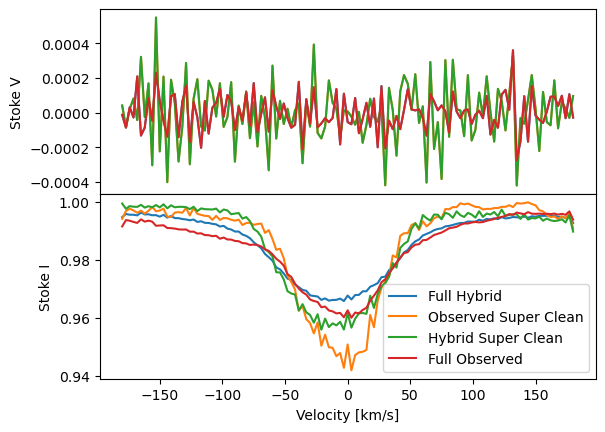

In [439]:
from LSDpy import lsdpy
velS=-180.0
velE=180.0
velP=3.0
outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_onlyHe_FH.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
lsd = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_onlyHe_UH.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UH = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/onlyHe_UO.lsd'.format(path)
toto = lsdpy.main(observation=file, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UO=pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/onlyHe_FO.lsd'.format(path)
toto = lsdpy.main(observation=file, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
FO=pol.read_lsd(outfile)


'''
outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_onlyHe_FH.lsd'.format(path,ModelCode3)
toto = lsdpy.main(observation=file23, mask=file_mask3, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
lsd3 = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_onlyHe_UH.lsd'.format(path,ModelCode3)
toto = lsdpy.main(observation=file23, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UH3 = pol.read_lsd(outfile)
'''

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(lsd.vel,lsd.specV)
ax[0].plot(UO.vel,UO.specV)
ax[0].plot(UH.vel,UH.specV)
ax[0].plot(FO.vel,FO.specV)
ax[1].plot(lsd.vel,lsd.specI,label='Full Hybrid'.format(ModelCode.upper()))
ax[1].plot(UO.vel,UO.specI,label='Observed Super Clean'.format(ModelCode.upper()))
ax[1].plot(UH.vel,UH.specI,label='Hybrid Super Clean'.format(ModelCode.upper()))
ax[1].plot(FO.vel,FO.specI,label='Full Observed'.format(ModelCode.upper()))

#ax[0].plot(lsd3.vel,lsd3.specV)
#ax[0].plot(UH3.vel,UH3.specV)
#ax[1].plot(lsd3.vel,lsd3.specI,label='{}, Full'.format(ModelCode3.upper()))
#ax[1].plot(UH3.vel,UH3.specI,label='{}, Super Clean'.format(ModelCode3.upper()))

ax[0].set_ylabel('Stoke V')
ax[1].set_ylabel('Stoke I')
ax[1].set_xlabel('Velocity [km/s]')
ax[1].legend()
#ax.set_title('Original')

plt.subplots_adjust(wspace=0, hspace=0)

## No He

In [440]:
file_mask='{}02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(path,ModelCode.upper())
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element<=2.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_noHe.mask'.format(path,ModelCode))



In [441]:
file_mask='{}02-Mask-calculations/MaskCleaning/AsifMaskSuperClean_tellClean/{}_clean_{}.mask'.format(path,star,1)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element<=2.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_noHe.mask'.format(path))




In [442]:
file = '{}00-InputMaterial/NormalizedSpectra/{}_1.s'.format(path,star)
data = pol.read_spectrum(file)

file2 = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode)
synth = pol.read_spectrum(file2)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_noHe.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)

file_mask2='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_noHe.mask'.format(path)
mask = pol.read_mask(fname=file_mask2)


file23 = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode3)
synth3 = pol.read_spectrum(file23)

file_mask3='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_noHe.mask'.format(path,ModelCode3)
mask3 = pol.read_mask(fname=file_mask3)



Average observed spec velocity spacing: 1.804761 km/s
using a 121 point profile with 3.000000 km/s pixels
mean mask depth 0.080482 wl 504.907 Lande 1.209248 (from 1007 lines)
mean mask norm weightI 0.402408 weightV 0.399528
I reduced chi2 133.2478 (chi2 12732891.93 constraints 95679 dof 121)
 Rescaling error bars by: 11.543300
V reduced chi2 1.0148 (chi2 96972.83 constraints 95679 dof 121)
 Rescaling error bars by: 1.007376
 removing profile continuum pol: -5.4303e-06 +/- 4.5496e-09 (avg err 6.7359e-05)
N1 reduced chi2 1.0188 (chi2 97351.50 constraints 95679 dof 121)
 Rescaling error bars by: 1.009341
 removing profile continuum pol: -4.5043e-06 +/- 4.5674e-09 (avg err 6.7490e-05)
(possible Stokes I uncertainty underestimate 1.9477e-03 vs 8.2208e-04)
line range estimate -57.0 36.0 km/s
V in line reduced chi^2 1.734550 (chi2  53.771059) 
 detect prob 0.993198 (fap 6.801973e-03)
 Marginal detection V (fap 6.801973e-03)
 V outside line reduced chi^2 1.122272 (chi2  94.270820) 
 detect pro

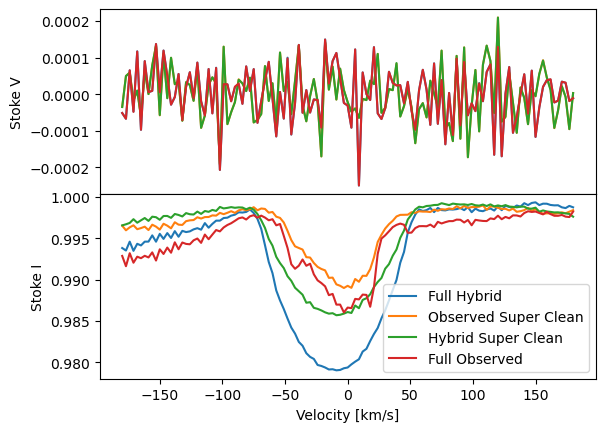

In [443]:
from LSDpy import lsdpy
velS=-180.0
velE=180.0
velP=3.0
outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_noHe_FH.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
lsd = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_noHe_UH.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UH = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/noHe_UO.lsd'.format(path)
toto = lsdpy.main(observation=file, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UO=pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/noHe_FO.lsd'.format(path)
toto = lsdpy.main(observation=file, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
FO=pol.read_lsd(outfile)


'''
outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_onlyHe_FH.lsd'.format(path,ModelCode3)
toto = lsdpy.main(observation=file23, mask=file_mask3, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
lsd3 = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_onlyHe_UH.lsd'.format(path,ModelCode3)
toto = lsdpy.main(observation=file23, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UH3 = pol.read_lsd(outfile)
'''

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(lsd.vel,lsd.specV)
ax[0].plot(UO.vel,UO.specV)
ax[0].plot(UH.vel,UH.specV)
ax[0].plot(FO.vel,FO.specV)
ax[1].plot(lsd.vel,lsd.specI,label='Full Hybrid'.format(ModelCode.upper()))
ax[1].plot(UO.vel,UO.specI,label='Observed Super Clean'.format(ModelCode.upper()))
ax[1].plot(UH.vel,UH.specI,label='Hybrid Super Clean'.format(ModelCode.upper()))
ax[1].plot(FO.vel,FO.specI,label='Full Observed'.format(ModelCode.upper()))

#ax[0].plot(lsd3.vel,lsd3.specV)
#ax[0].plot(UH3.vel,UH3.specV)
#ax[1].plot(lsd3.vel,lsd3.specI,label='{}, Full'.format(ModelCode3.upper()))
#ax[1].plot(UH3.vel,UH3.specI,label='{}, Super Clean'.format(ModelCode3.upper()))

ax[0].set_ylabel('Stoke V')
ax[1].set_ylabel('Stoke I')
ax[1].set_xlabel('Velocity [km/s]')
ax[1].legend()
#ax.set_title('Original')

plt.subplots_adjust(wspace=0, hspace=0)

## Only Carbon

In [444]:
file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_noHe.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element>=7.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_Conly.mask'.format(path,ModelCode))



In [445]:
file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_noHe.mask'.format(path)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element>=7.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_Conly.mask'.format(path))


In [446]:
file = '{}00-InputMaterial/NormalizedSpectra/{}_1.s'.format(path,star)
data = pol.read_spectrum(file)

file2 = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode)
synth = pol.read_spectrum(file2)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_Conly.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)

file_mask2='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_Conly.mask'.format(path)
mask = pol.read_mask(fname=file_mask2)



Average observed spec velocity spacing: 1.804761 km/s
using a 121 point profile with 3.000000 km/s pixels
mean mask depth 0.062646 wl 497.742 Lande 1.227576 (from 99 lines)
mean mask norm weightI 0.313232 weightV 0.295740
I reduced chi2 249.7802 (chi2 3351050.74 constraints 13537 dof 121)
 Rescaling error bars by: 15.804435
V reduced chi2 1.0108 (chi2 13560.65 constraints 13537 dof 121)
 Rescaling error bars by: 1.005376
 removing profile continuum pol: -2.5326e-05 +/- 1.1523e-07 (avg err 3.3903e-04)
N1 reduced chi2 1.0101 (chi2 13550.86 constraints 13537 dof 121)
 Rescaling error bars by: 1.005014
 removing profile continuum pol: -6.2982e-06 +/- 1.1515e-07 (avg err 3.3891e-04)
line range estimate -51.0 30.0 km/s
V in line reduced chi^2 0.972453 (chi2  25.283787) 
 detect prob 0.497040 (fap 5.029604e-01)
 Non-detection V (fap 5.029604e-01)
 V outside line reduced chi^2 0.945016 (chi2  84.106406) 
 detect prob 0.373155 (fap 6.268452e-01)
N1 in line reduced chi^2 0.911127 (chi2  23.68929

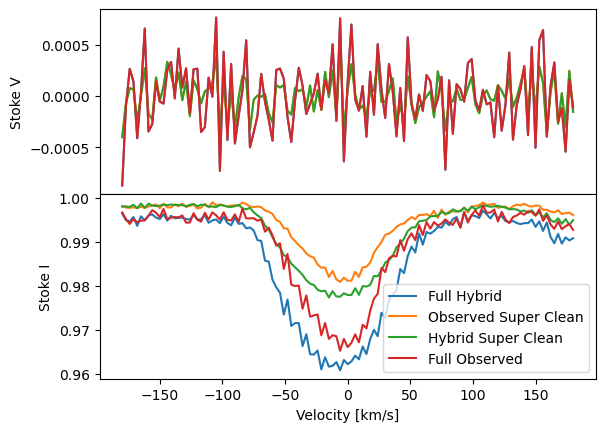

In [447]:
from LSDpy import lsdpy
velS=-180.0
velE=180.0
velP=3.0
outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_Conly_FH.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
lsd = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_Conly_UH.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UH = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/Conly_UO.lsd'.format(path)
toto = lsdpy.main(observation=file, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UO=pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/Conly_FO.lsd'.format(path)
toto = lsdpy.main(observation=file, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
FO=pol.read_lsd(outfile)


fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(lsd.vel,lsd.specV)
ax[0].plot(UO.vel,UO.specV)
ax[0].plot(UH.vel,UH.specV)
ax[0].plot(FO.vel,FO.specV)
ax[1].plot(lsd.vel,lsd.specI,label='Full Hybrid'.format(ModelCode.upper()))
ax[1].plot(UO.vel,UO.specI,label='Observed Super Clean'.format(ModelCode.upper()))
ax[1].plot(UH.vel,UH.specI,label='Hybrid Super Clean'.format(ModelCode.upper()))
ax[1].plot(FO.vel,FO.specI,label='Full Observed'.format(ModelCode.upper()))

#ax[0].plot(lsd3.vel,lsd3.specV)
#ax[0].plot(UH3.vel,UH3.specV)
#ax[1].plot(lsd3.vel,lsd3.specI,label='{}, Full'.format(ModelCode3.upper()))
#ax[1].plot(UH3.vel,UH3.specI,label='{}, Super Clean'.format(ModelCode3.upper()))

ax[0].set_ylabel('Stoke V')
ax[1].set_ylabel('Stoke I')
ax[1].set_xlabel('Velocity [km/s]')
ax[1].legend()
#ax.set_title('Original')

plt.subplots_adjust(wspace=0, hspace=0)

## No Carbon/He

In [448]:
file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_noHe.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element<7.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_noHe_noC.mask'.format(path,ModelCode))



In [449]:
file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_noHe.mask'.format(path)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element<7.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_noHe_noC.mask'.format(path))


In [450]:
file = '{}00-InputMaterial/NormalizedSpectra/{}_1.s'.format(path,star)
data = pol.read_spectrum(file)

file2 = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode)
synth = pol.read_spectrum(file2)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_noHe_noC.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)

file_mask2='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_noHe_noC.mask'.format(path)
mask = pol.read_mask(fname=file_mask2)



Average observed spec velocity spacing: 1.804761 km/s
using a 121 point profile with 3.000000 km/s pixels
mean mask depth 0.082426 wl 505.689 Lande 1.207250 (from 908 lines)
mean mask norm weightI 0.412131 weightV 0.410844
I reduced chi2 143.7189 (chi2 13394311.94 constraints 93319 dof 121)
 Rescaling error bars by: 11.988281
V reduced chi2 1.0155 (chi2 94643.79 constraints 93319 dof 121)
 Rescaling error bars by: 1.007727
 removing profile continuum pol: -5.0113e-06 +/- 4.7458e-09 (avg err 6.8794e-05)
N1 reduced chi2 1.0184 (chi2 94910.51 constraints 93319 dof 121)
 Rescaling error bars by: 1.009146
 removing profile continuum pol: -4.5892e-06 +/- 4.7592e-09 (avg err 6.8891e-05)
(possible Stokes I uncertainty underestimate 2.1558e-03 vs 8.7778e-04)
line range estimate -54.0 33.0 km/s
V in line reduced chi^2 1.756021 (chi2  50.924622) 
 detect prob 0.992833 (fap 7.166916e-03)
 Marginal detection V (fap 7.166916e-03)
 V outside line reduced chi^2 1.062863 (chi2  91.406224) 
 detect prob

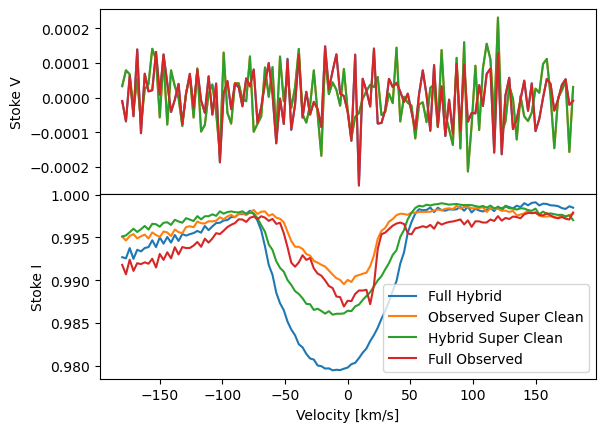

In [451]:
from LSDpy import lsdpy
velS=-180.0
velE=180.0
velP=3.0
outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_noHe_noC_FH.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
lsd = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_noHe_noC.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UH = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/noHe_noC_UO.lsd'.format(path)
toto = lsdpy.main(observation=file, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UO=pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/noHe_noC_FO.lsd'.format(path)
toto = lsdpy.main(observation=file, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
FO=pol.read_lsd(outfile)


fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(lsd.vel,lsd.specV)
ax[0].plot(UO.vel,UO.specV)
ax[0].plot(UH.vel,UH.specV)
ax[0].plot(FO.vel,FO.specV)
ax[1].plot(lsd.vel,lsd.specI,label='Full Hybrid'.format(ModelCode.upper()))
ax[1].plot(UO.vel,UO.specI,label='Observed Super Clean'.format(ModelCode.upper()))
ax[1].plot(UH.vel,UH.specI,label='Hybrid Super Clean'.format(ModelCode.upper()))
ax[1].plot(FO.vel,FO.specI,label='Full Observed'.format(ModelCode.upper()))

#ax[0].plot(lsd3.vel,lsd3.specV)
#ax[0].plot(UH3.vel,UH3.specV)
#ax[1].plot(lsd3.vel,lsd3.specI,label='{}, Full'.format(ModelCode3.upper()))
#ax[1].plot(UH3.vel,UH3.specI,label='{}, Super Clean'.format(ModelCode3.upper()))

ax[0].set_ylabel('Stoke V')
ax[1].set_ylabel('Stoke I')
ax[1].set_xlabel('Velocity [km/s]')
ax[1].legend()
#ax.set_title('Original')

plt.subplots_adjust(wspace=0, hspace=0)

## Only Carbon

In [21]:
ModelCode='T23000G35_45'

In [22]:
file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_Conly.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)
#mask.iuse[np.where(mask.element>=8.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_Conly.mask'.format(path,ModelCode))



In [23]:
file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_noHe.mask'.format(path)
mask = pol.read_mask(fname=file_mask)
#mask.iuse[np.where(mask.element>=8.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_Conly.mask'.format(path))


In [24]:
file = '{}00-InputMaterial/NormalizedSpectra/{}_1.s'.format(path,star)
data = pol.read_spectrum(file)

file2 = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode)
synth = pol.read_spectrum(file2)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_Conly.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)

file_mask2='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_Conly.mask'.format(path)
mask = pol.read_mask(fname=file_mask2)



Average observed spec velocity spacing: 1.804761 km/s
using a 121 point profile with 3.000000 km/s pixels
mean mask depth 0.102317 wl 503.183 Lande 1.190717 (from 1115 lines)
mean mask norm weightI 0.511587 weightV 0.498115
I reduced chi2 72.7363 (chi2 7301556.07 constraints 100505 dof 121)
 Rescaling error bars by: 8.528555
V reduced chi2 1.0176 (chi2 102154.52 constraints 100505 dof 121)
 Rescaling error bars by: 1.008780
 removing profile continuum pol: -4.8277e-06 +/- 2.9064e-09 (avg err 5.3805e-05)
N1 reduced chi2 1.0235 (chi2 102739.92 constraints 100505 dof 121)
 Rescaling error bars by: 1.011667
 removing profile continuum pol: -1.6394e-06 +/- 2.9231e-09 (avg err 5.3959e-05)
line range estimate -72.0 54.0 km/s
V in line reduced chi^2 1.215265 (chi2  51.041144) 
 detect prob 0.840139 (fap 1.598606e-01)
 Non-detection V (fap 1.598606e-01)
 V outside line reduced chi^2 1.296392 (chi2  94.636596) 
 detect prob 0.954786 (fap 4.521446e-02)
N1 in line reduced chi^2 0.791536 (chi2  33.

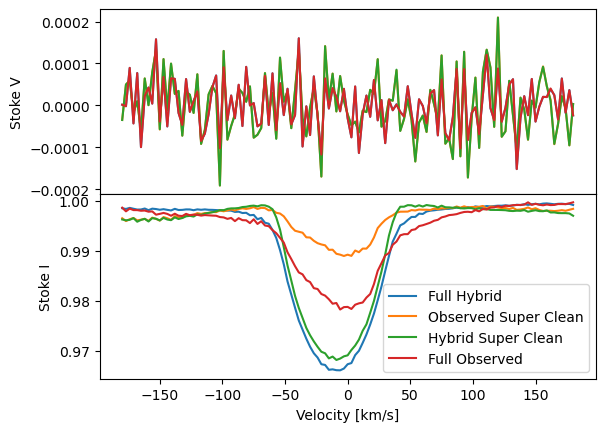

In [25]:
from LSDpy import lsdpy
velS=-180.0
velE=180.0
velP=3.0
outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_Conly_FH.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
lsd = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_Conly_UH.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UH = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/Conly_UO.lsd'.format(path)
toto = lsdpy.main(observation=file, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UO=pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/Conly_FO.lsd'.format(path)
toto = lsdpy.main(observation=file, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
FO=pol.read_lsd(outfile)


fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(lsd.vel,lsd.specV)
ax[0].plot(UO.vel,UO.specV)
ax[0].plot(UH.vel,UH.specV)
ax[0].plot(FO.vel,FO.specV)
ax[1].plot(lsd.vel,lsd.specI,label='Full Hybrid'.format(ModelCode.upper()))
ax[1].plot(UO.vel,UO.specI,label='Observed Super Clean'.format(ModelCode.upper()))
ax[1].plot(UH.vel,UH.specI,label='Hybrid Super Clean'.format(ModelCode.upper()))
ax[1].plot(FO.vel,FO.specI,label='Full Observed'.format(ModelCode.upper()))

#ax[0].plot(lsd3.vel,lsd3.specV)
#ax[0].plot(UH3.vel,UH3.specV)
#ax[1].plot(lsd3.vel,lsd3.specI,label='{}, Full'.format(ModelCode3.upper()))
#ax[1].plot(UH3.vel,UH3.specI,label='{}, Super Clean'.format(ModelCode3.upper()))

ax[0].set_ylabel('Stoke V')
ax[1].set_ylabel('Stoke I')
ax[1].set_xlabel('Velocity [km/s]')
ax[1].legend()
#ax.set_title('Original')

plt.subplots_adjust(wspace=0, hspace=0)

## Only ____

In [ ]:
import copy
# reading the observed spectrum
file_obs = '{}00-InputMaterial/NormalizedSpectra/{}_{}.s'.format(path,star, 1)
data_obs = pol.read_spectrum(file_obs)
# splitting the observed spectrum by order
list_order = split_order(data_obs)

vsini=45
ModelCode='T23000G35_45'
file_mod = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.dsk'.format(path,ModelCode)
mod_wave, mod_flux = read_disk(file_mod)
# shifting the model spectrum for its radial velocity
# (note the rshift function asks for numpy unit quantities)

mod_wave_shift = rshift(mod_wave*u.nm, vradCorrected)

for order in list_order:

  # interpolate the shifted model onto the order grid
  mod_flux_interp = np.interp(order.wl, mod_wave_shift, mod_flux)

  # drawing n random elements with a mean of zero and a stdev of 1.0
  # scaling to a sigma corresponding to the error bar
  noise = np.random.standard_normal(order.wl.size)*order.specSig
  mod_flux_interp = mod_flux_interp + noise
  # replacing the flux array in the order
  order.specI = copy.deepcopy(mod_flux_interp)

# putting the orders back together
new = splice_order(list_order)

### writting back the file in the proper folder. 
## need to look for a write function for .s, maybe in Colin's 
## normalization code?

new.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode))

In [32]:
ModelCode='T17000G35_45'
vsini=45

In [33]:
file_mask='{}02-Mask-calculations/MaskCleaning/depth0.02_tellClean/T17000G35_depth0.02.mask'.format(path,ModelCode.upper())
mask = pol.read_mask(fname=file_mask)
#mask.iuse[np.where([mask.element==14.01,mask.element==14.02,mask.element==14.03,mask.element==16.01,mask.element==16.02])[1]]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_Conly.mask'.format(path,ModelCode))



In [34]:
file_mask='{}02-Mask-calculations/MaskCleaning/AsifMaskSuperClean_tellClean/{}_clean_{}.mask'.format(path,star,2)
mask = pol.read_mask(fname=file_mask)
#mask.iuse[np.where([mask.element==14.01,mask.element==14.02,mask.element==14.03,mask.element==16.01,mask.element==16.02])[1]]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_Conly.mask'.format(path))




In [35]:
file = '{}00-InputMaterial/NormalizedSpectra/{}_1.s'.format(path,star)
data = pol.read_spectrum(file)

file2 = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}.s'.format(path,ModelCode)
synth = pol.read_spectrum(file2)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_Conly.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)

file_mask2='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/uncontaminated_Conly.mask'.format(path)
mask = pol.read_mask(fname=file_mask2)



Average observed spec velocity spacing: 1.804761 km/s
using a 121 point profile with 3.000000 km/s pixels
mean mask depth 0.088584 wl 506.184 Lande 1.209929 (from 1049 lines)
mean mask norm weightI 0.442922 weightV 0.436111
I reduced chi2 66.6634 (chi2 6471751.80 constraints 97202 dof 121)
 Rescaling error bars by: 8.164767
V reduced chi2 1.0158 (chi2 98614.42 constraints 97202 dof 121)
 Rescaling error bars by: 1.007867
 removing profile continuum pol: -4.7455e-06 +/- 3.1486e-09 (avg err 5.6000e-05)
N1 reduced chi2 1.0197 (chi2 98998.10 constraints 97202 dof 121)
 Rescaling error bars by: 1.009825
 removing profile continuum pol: -2.2109e-06 +/- 3.1609e-09 (avg err 5.6109e-05)
(possible Stokes I uncertainty underestimate 1.2867e-03 vs 4.7295e-04)
line range estimate -60.0 39.0 km/s
V in line reduced chi^2 1.970663 (chi2  65.031870) 
 detect prob 0.999271 (fap 7.294701e-04)
 Marginal detection V (fap 7.294701e-04)
 V outside line reduced chi^2 1.181481 (chi2  96.881430) 
 detect prob 0

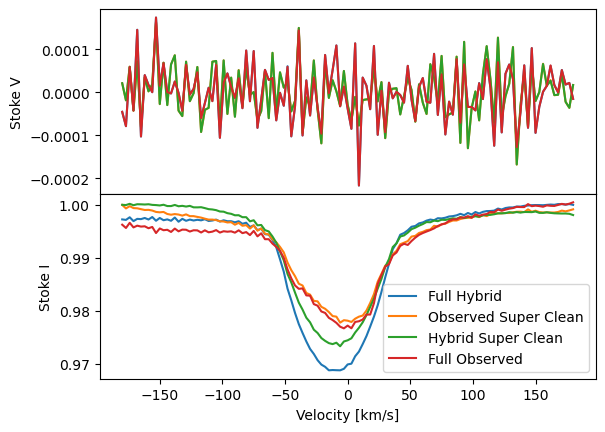

In [36]:
from LSDpy import lsdpy
velS=-180.0
velE=180.0
velP=3.0
outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_Conly_FH.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
lsd = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/{}_Conly_UH.lsd'.format(path,ModelCode)
toto = lsdpy.main(observation=file2, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UH = pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/Conly_UO.lsd'.format(path)
toto = lsdpy.main(observation=file, mask=file_mask2, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
UO=pol.read_lsd(outfile)

outfile='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/PosterChildSpectra/Conly_FO.lsd'.format(path)
toto = lsdpy.main(observation=file, mask=file_mask, outName=outfile, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
FO=pol.read_lsd(outfile)


fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(lsd.vel,lsd.specV)
ax[0].plot(UO.vel,UO.specV)
ax[0].plot(UH.vel,UH.specV)
ax[0].plot(FO.vel,FO.specV)
ax[1].plot(lsd.vel,lsd.specI,label='Full Hybrid'.format(ModelCode.upper()))
ax[1].plot(UO.vel,UO.specI,label='Observed Super Clean'.format(ModelCode.upper()))
ax[1].plot(UH.vel,UH.specI,label='Hybrid Super Clean'.format(ModelCode.upper()))
ax[1].plot(FO.vel,FO.specI,label='Full Observed'.format(ModelCode.upper()))

#ax[0].plot(lsd3.vel,lsd3.specV)
#ax[0].plot(UH3.vel,UH3.specV)
#ax[1].plot(lsd3.vel,lsd3.specI,label='{}, Full'.format(ModelCode3.upper()))
#ax[1].plot(UH3.vel,UH3.specI,label='{}, Super Clean'.format(ModelCode3.upper()))

ax[0].set_ylabel('Stoke V')
ax[1].set_ylabel('Stoke I')
ax[1].set_xlabel('Velocity [km/s]')
ax[1].legend()
#ax.set_title('Original')

plt.subplots_adjust(wspace=0, hspace=0)

In [552]:
[2,12,17?,22?,28?] #good


SyntaxError: invalid syntax (922769032.py, line 1)

In [ ]:
[14,16,26] #very bad

In [535]:
60/np.sin(10*np.pi/180)

345.5262289886181